# Cloud Image Classification

In [35]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

from torchvision.datasets import ImageFolder
from torchvision import transforms

from torchmetrics import Recall, Precision

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [62]:
import os

valid_extensions = (".jpg")

count_train = sum(
    len([file for file in files if file.endswith(valid_extensions)]) 
    for _, _, files in os.walk("../content/clouds_train")
)
count_test = sum(
    len([file for file in files if file.endswith(valid_extensions)]) 
    for _, _, files in os.walk("../content/clouds_test")
)

print(f"Total Train images: {count_train}")
print(f"Total Test images: {count_test}")


Total Train images: 474
Total Test images: 486


##### Define Transformation

In [36]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
		transforms.RandomRotation(45),
		transforms.RandomAutocontrast(),
		transforms.ToTensor(),
		transforms.Resize((128, 128)),
])

In [37]:
dataset_train_val = ImageFolder(
		"../content/clouds_train",
		transform=train_transforms,
)

train_size = int(0.9 * len(dataset_train_val))
val_size = len(dataset_train_val) - train_size
train_dataset, val_dataset = random_split(dataset_train_val, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)

In [38]:
# Store one image per label
images_per_label = {}

for images, labels in train_loader:
    for image, label in zip(images, labels):
        label = label.item()  # convert tensor to int

        # Store only first example
        if label not in images_per_label:
            images_per_label[label] = image

        # Stop when already collected all 7 labels
        if len(images_per_label) == 7:
            break
    if len(images_per_label) == 7:
        break

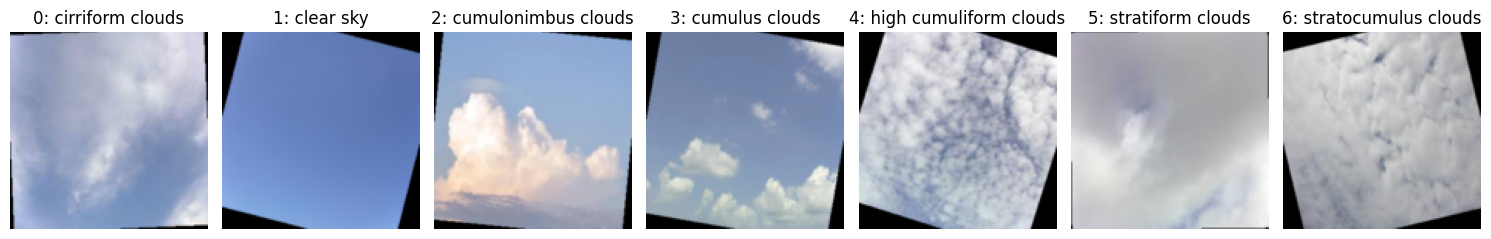

In [39]:
fig, axes = plt.subplots(1, 7, figsize=(15, 5))
class_names = dataset_train_val.classes

for i, ax in enumerate(axes):
    image = images_per_label[i].squeeze().permute(1, 2, 0)  # Change shape to show image
    ax.imshow(image)
    ax.set_title(f"{i}: {class_names[i]}")
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [40]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*32*32, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
net = Net(num_classes = 7)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

In [42]:
# Early stopping parameters
patience = 10 # Number of epochs to wait before stopping
min_val_loss = float('inf') # Initialize with a very high value
count = 0 # Tracks how many epochs the val_loss hasn't improved
best_model_state = None

# epoch
num_epochs = 200
train_loss = []
val_loss = []

In [43]:
for epoch in range(num_epochs):
    net.train()
    training_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validation Phase
    net.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping check
    if epoch_val_loss < min_val_loss:
      min_val_loss = epoch_val_loss
      count = 0

      # Store the best net so the net will not keep the last-trained weights instead of the best-performing ones
      best_model_state = net.state_dict()
    else:
      count += 1
      if count >= patience:
        epoch = epoch + 1 # assign variable for plotting
        print(print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch: {epoch}/{num_epochs}"))
        break

net.train()

Epoch 1/200 - Train Loss: 2.0605, Val Loss: 1.5890
Epoch 2/200 - Train Loss: 1.5221, Val Loss: 1.4767
Epoch 3/200 - Train Loss: 1.4639, Val Loss: 1.2425
Epoch 4/200 - Train Loss: 1.3012, Val Loss: 1.2843
Epoch 5/200 - Train Loss: 1.2789, Val Loss: 1.3348
Epoch 6/200 - Train Loss: 1.2671, Val Loss: 1.3789
Epoch 7/200 - Train Loss: 1.2770, Val Loss: 1.2611
Epoch 8/200 - Train Loss: 1.3614, Val Loss: 1.2674
Epoch 9/200 - Train Loss: 1.1494, Val Loss: 1.1802
Epoch 10/200 - Train Loss: 1.0911, Val Loss: 1.1645
Epoch 11/200 - Train Loss: 1.1257, Val Loss: 1.0436
Epoch 12/200 - Train Loss: 1.0437, Val Loss: 1.0755
Epoch 13/200 - Train Loss: 1.1369, Val Loss: 0.9958
Epoch 14/200 - Train Loss: 1.1809, Val Loss: 1.1508
Epoch 15/200 - Train Loss: 1.0070, Val Loss: 1.2830
Epoch 16/200 - Train Loss: 0.9145, Val Loss: 0.9014
Epoch 17/200 - Train Loss: 1.0459, Val Loss: 1.0077
Epoch 18/200 - Train Loss: 1.0375, Val Loss: 1.3481
Epoch 19/200 - Train Loss: 1.0444, Val Loss: 1.3006
Epoch 20/200 - Train 

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=65536, out_features=7, bias=True)
)

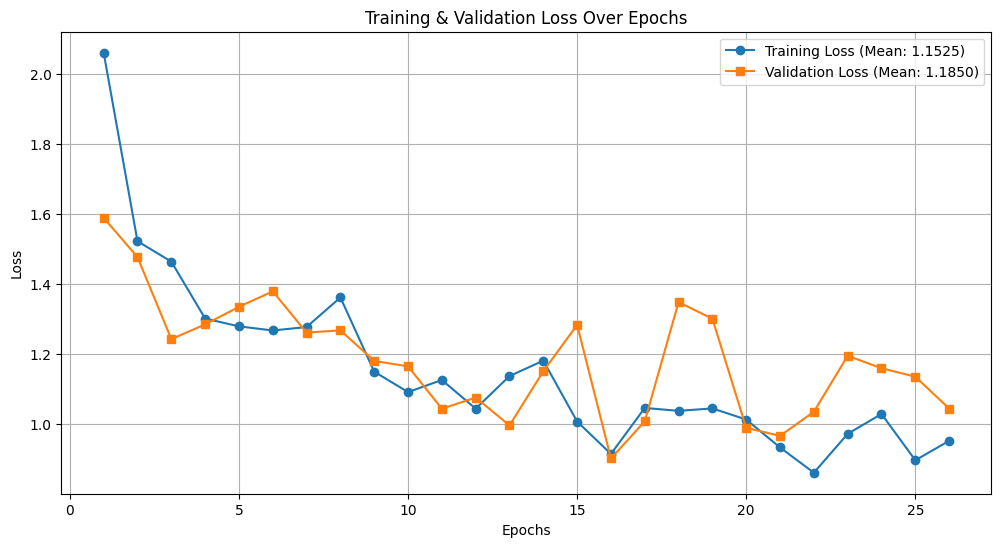

In [44]:
mean_train_loss = sum(train_loss) / len(train_loss)
mean_val_loss = sum(val_loss) / len(val_loss)

# Plot the Loss Curve
if num_epochs > epoch + 1:
    range_epoch = epoch
else: range_epoch = num_epochs

plt.figure(figsize = (12, 6))
plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [45]:
if best_model_state:
    net.load_state_dict(best_model_state)

In [46]:
test_transforms = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((128, 128)),
])

dataset_test = ImageFolder(
		"../content/clouds_test",
		transform=test_transforms,
)

test_loader = DataLoader(dataset_test, batch_size=16, shuffle=True)

In [47]:
precision_micro = Precision(task='multiclass', num_classes=7, average='micro')
recall_micro = Recall(task='multiclass', num_classes=7, average='micro')

precision_per_class = Precision(task='multiclass', num_classes=7, average=None)
recall_per_class = Recall(task='multiclass', num_classes=7, average=None)

testing_loss = 0.0

net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        precision_micro(preds, labels)
        recall_micro(preds, labels)
        precision_per_class(preds, labels)
        recall_per_class(preds, labels)

average_test_loss = testing_loss / len(test_loader)
print(f'Testing Loss: {average_test_loss:.4f}')

Testing Loss: 0.9707


In [48]:
print(f"Precision: {precision_micro.compute():.4f}")
print(f"Recall: {recall_micro.compute():.4f}")

Precision: 0.6049
Recall: 0.6049


In [49]:
dataset_test.class_to_idx

{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}

In [50]:
recall_per_class_dict = {
    k: recall_per_class.compute()[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(recall_per_class_dict)

{'cirriform clouds': 0.5844155550003052, 'clear sky': 0.625, 'cumulonimbus clouds': 0.9090909361839294, 'cumulus clouds': 0.6333333253860474, 'high cumuliform clouds': 0.8058252334594727, 'stratiform clouds': 0.8500000238418579, 'stratocumulus clouds': 0.0845070406794548}


In [51]:
precision_per_class_dict = {
    k: precision_per_class.compute()[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class_dict)

{'cirriform clouds': 0.5056179761886597, 'clear sky': 0.930232584476471, 'cumulonimbus clouds': 0.7692307829856873, 'cumulus clouds': 0.6608695387840271, 'high cumuliform clouds': 0.46368715167045593, 'stratiform clouds': 0.8717948794364929, 'stratocumulus clouds': 0.75}
